In [52]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from collections import Counter

from nltk import word_tokenize
from time import time
import pandas as pd
import re
import numpy as np
import gensim
import string

In [43]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/ktyser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ktyser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
training_set = pd.read_csv("Train.csv")
training_set.sample(5)

,ID,Text,Label
72,ID_DFyFIiZt,Ambuye Ziyaye Apempha Achinyamata Amasuke Posa...,RELIGION
159,ID_GOSzgJdo,Amukwenya ponena olumala kuti agalu Banja li...,LAW/ORDER
916,ID_iEixECkL,Papa Wapempha Akhristu Kukhala a Chikhulupirir...,RELIGION
966,ID_jpraLflT,Njengunje pothana ndi matenda a khansa Muli n...,HEALTH
127,ID_EtUHjqWm,"Mwana wa zaka 13, mavuto osakata Ikakuona lit...",SOCIAL ISSUES


In [45]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1436 non-null   object
 1   Text    1436 non-null   object
 2   Label   1436 non-null   object
dtypes: object(3)
memory usage: 33.8+ KB


In [46]:
test_set = pd.read_csv("Test.csv")
test_set.sample(5)

,ID,Text
358,ID_eaTqdPbI,Mwaulambia alowa mmanda lero Adali ndi nzeru:...
79,ID_GPkkKBXb,Ambuye Msusa Apempha Akhristu Achulutse Mapemp...
233,ID_SzZkVkrs,A Chiwembu Abera Munthu 2 Million Kwacha Wolem...
270,ID_WmVIvpKr,Kuli ziii! za mapulaimale Pamene ntchito ya k...
45,ID_DfbhJMQN,La Nina wachita katondo Mmene mitambo ya mvul...


Text(0.5, 1.0, 'Classes distribution')

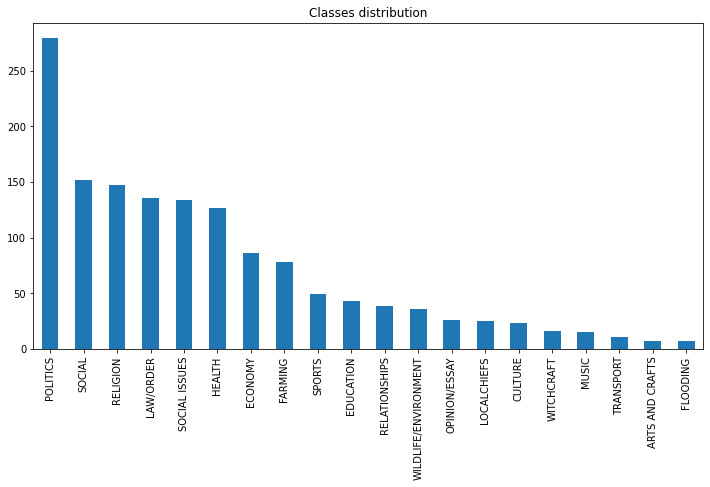

In [6]:
training_set.Label.value_counts().plot.bar(figsize=(12, 6))
plt.title('Classes distribution')

In [47]:
punctuations = string.punctuation + "’¶•@°©®™"

In [48]:
def preprocess_text(text):
    """
    @param text string
    @return text string
    
    This function preprocess a given raw text by normalizing it to lowercase removing the stop words,
    punctuations and lemmatization
    """
        
    #string to lowercase
    txt = text.lower()
    
    # keep only ascii characters
    txt = re.sub(r"[^a-zA-ZÀ-ÿ]", " ", txt)
    
    # punctuation removal and map it to space
    translator = str.maketrans(punctuations, " "*len(punctuations))
    s = txt.translate(translator)
    
    # remove digits 
    no_digits = ''.join([i for i in s if not i.isdigit()])
    cleaner = " ".join(no_digits.split())
    
    # tokenize words and removing stop words 
    word_tokens = word_tokenize(cleaner)
    filtered_sentence = [w for w in word_tokens if len(w)>2 ]
    filtered_sentence = " ".join(filtered_sentence)
    
    return filtered_sentence

In [49]:
# testing function
sample_text = training_set.Text[7]
print("RAW text before preprocessing :\n")
print(sample_text)
print("\n-------------------------------\n")
print("Processed text after preprocessing :\n")
print(preprocess_text(sample_text))

RAW text before preprocessing :

 Mayi wamalonda avulazidwa ku bt Titha Masamba, wa zaka 31, akumva ululu wadzaoneni. Kuti ayende akuyenera agwirire ndodo; sangagone chafufumimba koma chammbali kapena chagada; moyo wamtendere watha.
 Akuti adamuphera tsogolo lake: Masamba kumva ululu kunyumba kwake Akuti izitu zili chonchi chifukwa cha bala lomwe lili pabondo lake la kumanja lomwe lidasokedwa kuchipatala pambuyo pokhapidwa ndi chikwanje.
  Chisale watuluka nkumangidwanso  Sipakala waimitsa Nyumba ya Malamulo  Pa Wenela pasintha zedi Ulendo wa mayiyu wokagulitsa mandasi pa 7 July ndi womwe udabweretsa mavutowa pomwe anthu ena, omwe akuwaganizira kuti ogwira ntchito kukhonsolo ya mzinda wa Blantyre (city rangers) amene adamuchita chiwembu pomulanda malonda ake komanso kumuvulaza ndi chikwanje.
 Masamba akuti atangomwalira amuna ake mu 2007, iye adayamba geni yogulitsa mandasi kuti azisamalira banja lake la ana awiri. Malo amene amagulitsira malonda akewo akuti ndi ku Cold Storage pafupi 

In [50]:
# Applying the preprocessing function through all the data
training_set['clean_text'] = training_set.Text.apply(preprocess_text)
test_set['clean_text'] = test_set.Text.apply(preprocess_text)

<AxesSubplot:xlabel='Word'>

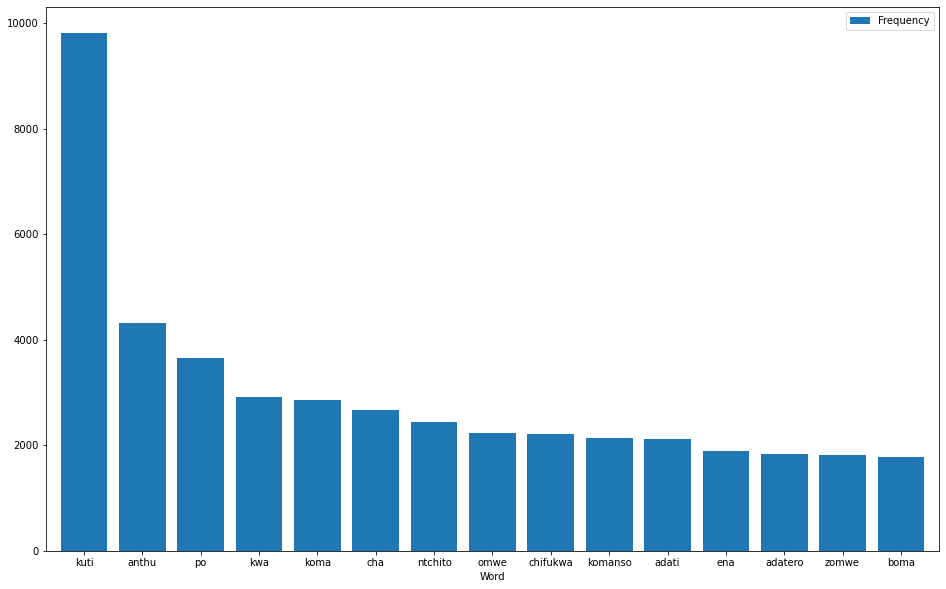

In [68]:
rslt = pd.DataFrame(Counter(" ".join(training_set["clean_text"]).split()).most_common(15),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

In [54]:
training_set['clean_text'] = training_set['clean_text'].str.replace('ndi', '').replace('kuti', '')
test_set['clean_text'] = test_set['clean_text'].str.replace('ndi', '').replace('kuti', '')

In [55]:
training_set.sample(5)

,ID,Text,Label,clean_text
403,ID_PWLZfOrU,Aphungu apane boma posakaza chuma Pamene aphu...,POLITICS,aphungu apane boma posakaza chuma pamene aphun...
570,ID_VDWMzMgI,Kodi malubino tilowere kuti? Kodi tilowere ku...,LAW/ORDER,kodi malubino tilowere kuti kodi tilowere kuti...
1041,ID_nAkOThqP,Papa Wapempha Abambo Akhale Olimba pa Chikhris...,RELIGION,papa wapempha abambo akhale olimba chikhristu ...
586,ID_VqVEqfnF,Akhristu 100 Alandira Ulimbitso ku Parish ya M...,RELIGION,akhristu alara ulimbitso parish mpiri wolemba ...
1040,ID_nAiGatgJ,"Anatchezera Sakuthandiza Agogo, Pa Wenela pa...",RELATIONSHIPS,anatchezera sakuthaza agogo wenela pasintha ze...


In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("classifier", LogisticRegression()),
    ]
)

In [57]:
parameters = {
   'classifier__penalty' : ['l1', 'l2'],
   'classifier__C' : np.logspace(-4, 4, 20),
   'classifier__solver' : ['liblinear']
}

In [58]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [59]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(training_set['clean_text'], training_set['Label'])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'classifier']
parameters:
{'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
 'classifier__penalty': ['l1', 'l2'],
 'classifier__solver': ['liblinear']}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
done in 76.296s

Best score: 0.646
Best parameters set:
	classifier__C: 545.5594781168514
	classifier__penalty: 'l2'
	classifier__solver: 'liblinear'


In [60]:
%%time
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("classifier", LogisticRegression(C=545.5594781168514, solver='liblinear', penalty='l2')),
    ]
)

CPU times: user 118 µs, sys: 49 µs, total: 167 µs
Wall time: 175 µs


In [61]:
scores = cross_val_score(pipeline, training_set['clean_text'], training_set['Label'], cv=5, scoring='precision_micro')
print(scores)

[0.62847222 0.63414634 0.67247387 0.64808362 0.64808362]


In [62]:
print(f"Final score is {scores.mean()}")

Final score is 0.646251935733643


In [63]:
pipeline.fit( training_set['clean_text'], training_set['Label'])
test_set.loc[:,"Label"] = pipeline.predict(test_set['Text'])

In [64]:
test_set[['ID','Label']]

,ID,Label
0,ID_ADHEtjTi,SOCIAL ISSUES
1,ID_AHfJktdQ,RELIGION
2,ID_AUJIHpZr,RELATIONSHIPS
3,ID_AUKYBbIM,SOCIAL ISSUES
4,ID_AZnsVPEi,HEALTH
...,...,...
615,ID_zdpOUWyJ,LAW/ORDER
616,ID_zhnOomuu,RELATIONSHIPS
617,ID_zmWHvBJb,LAW/ORDER
618,ID_zphjdFIb,SOCIAL ISSUES


In [67]:
#test_set[['ID','Label']].to_csv("submission.csv", index=False) 